In [1]:
#conda install -c gurobi gurobi
#conda install -c conda-forge python-graphviz
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np
#from networkx.drawing.nx_agraph import graphviz_layout

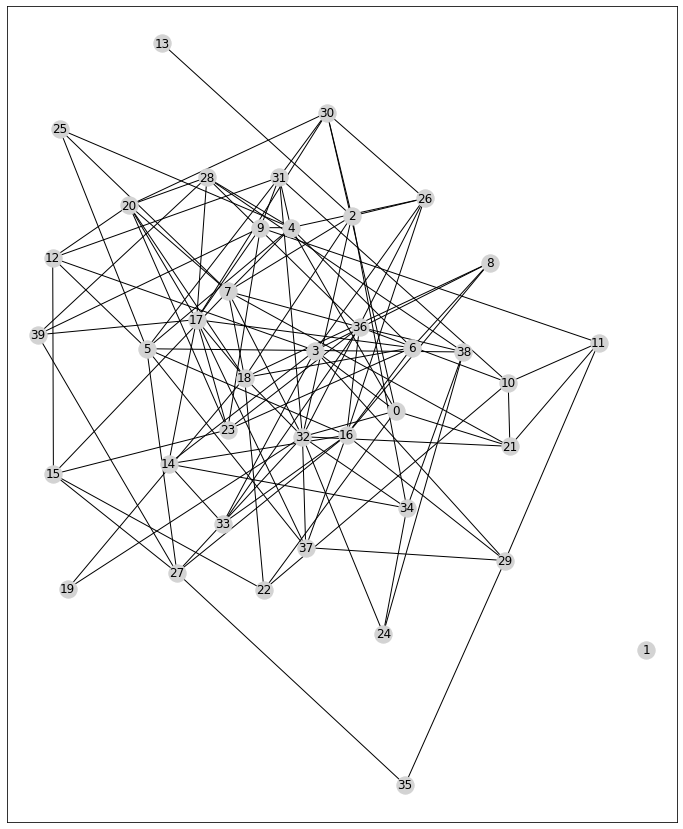

In [2]:
# generate random graph for example of office network
# number of people = nodes
nodes = 40
# erdos renyi graph as pretend graph; n=35 and p=.2
G = nx.erdos_renyi_graph(nodes, .15, seed=2, directed=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 15))
random_pos = nx.spring_layout(G, k=0.8, seed=18)
nx.draw_networkx(G, ax=ax, pos = random_pos, node_color = "lightgrey")

In [3]:
#define parameters
n_people = nodes
# Number of cohorts (can adjust this; 5 so that each cohort can work in office once a week)
total_cohorts = 3
# Minimum amount of people per cohort (to ensure some level of social interaction)
min_cohort_size = 10
# Maximum amount of people per cohort (to ensure distancing and capacity constraints)
max_cohort_size = 20
# Matrix of nodes and neighbors (1 if nodes are adjacent; 0 if nodes are not adjacent)
neighbor_mat = nx.adjacency_matrix(G).toarray()
neighbor_mat
print(neighbor_mat[0,2])
print(neighbor_mat)

0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# Cost matrix of the adjacency for minimization prob (0 if nodes are adjacent; 1 if nodes are not adjacent))
cost_mat = np.zeros((n_people, n_people))
for i in range(len(cost_mat)):
    for j in range(len(cost_mat)):
        adj = neighbor_mat[i,j]
        if adj == 0: 
            cost_mat[i,j] = 1
print(cost_mat)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [5]:
cohort_generator = Model()
#optimization problem set up
#Decision variable 
X={}
Y={}
#person
for p in range(n_people):
    #potential teammate of person
    for t in range(n_people):
        #cohort assignment of potential teammates
        for c in range(total_cohorts):
            #decision variable, Y, binary variable. Objective value is the sum of product of each X_pct and cost matrix Y_pc element
            #Y_pc takes on 1 if person p is in cohort c, and 0 otherwise
            Y[(p,c)] = cohort_generator.addVar(vtype = GRB.BINARY, obj = 0, 
                                          name = 'person, cohort assignment: (p,c): (%s,%s) ' %(p+1,c+1))
            #decision variable, x, binary variable. Objective value is the sum of product of each X_pct and cost matrix Y_pc element 
            #X_ptc takes on 1 if person p and teammate t are together in cohort c, and 0 otherwise
            if p > t:
                X[(p,t,c)] = cohort_generator.addVar(vtype = GRB.BINARY, obj = cost_mat[p][t], 
                                              name = 'person, cohort assignment: (p,t,c): (%s,%s, %s) ' %(p+1, t+1, c+1))
cohort_generator.update()
cohort_generator.modelSense = GRB.MINIMIZE


Using license file C:\Users\danielle.heymann\gurobi.lic


In [ ]:
#constraints

# 1. Cohort Unique Membership Constraint
# Sum (over 1..C) Y_pc, (for 1..P) = 1
for p in range(n_people):        
        cohort_generator.addConstr(quicksum(Y[(p,c)] for c in range(total_cohorts)) == 1)
        
# 2-3. Upper and lower bounds on X_ptc
# When Y_pc and Y_tc are 1, X_ptc needs to be 1
# When only Y_pc and not Y_tc is 1, X_ptc needs to be 0
for p in range(n_people):
    for t in range(n_people):
        for c in range(total_cohorts):
            if p > t :
                cohort_generator.addConstr(X[(p,t,c)] <= (Y[(p,c)] + Y[(t,c)])/2)
for p in range(n_people):
    for t in range(n_people):
        for c in range(total_cohorts):
            if p > t :
                cohort_generator.addConstr(X[(p,t,c)] >= (Y[(p,c)] + Y[(t,c)]) - 1)            
            
# 4. Cohort Minimum Size Constraint
# Sum (over 1..P) Y_pc >= min_cohort_size, (for 1..C) 
for c in range(total_cohorts):
    cohort_generator.addConstr(quicksum(Y[(p,c)] for p in range(n_people)) >= min_cohort_size)

# 5. Cohort Maximum Size Constraint
# Sum (over 1..P) Y_pc <= max_cohort_size, (for 1..C)
for c in range(total_cohorts):
    cohort_generator.addConstr(quicksum(Y[(p,c)] for p in range(n_people)) <= max_cohort_size)

# agressive presolve
cohort_generator.Params.Presolve = 2
#cohort_generator.setParam('TimeLimit', 240)
cohort_generator.optimize()

Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4726 rows, 7140 columns and 14400 nonzeros
Model fingerprint: 0x96dd3678
Variable types: 0 continuous, 7140 integer (7140 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 217.0000000
Presolve removed 0 rows and 4680 columns
Presolve time: 0.18s
Presolved: 4726 rows, 2460 columns, 16740 nonzeros
Variable types: 0 continuous, 2460 integer (2460 binary)
Presolve removed 117 rows and 114 columns
Presolved: 4609 rows, 2349 columns, 16167 nonzeros


Root relaxation: objective 0.000000e+00, 118 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

 22315 15199  121.98012   49  686  179.00000   76.93731  57.0%   133  415s
 22389 15218  139.44555   54  643  179.00000   77.51749  56.7%   136  424s
 22465 15225   84.82945   44  829  179.00000   78.92793  55.9%   138  436s
 22511 15275   95.57439   50  809  179.00000   78.92793  55.9%   141  446s
 22584 15316  103.88997   66  814  179.00000   78.92793  55.9%   143  456s
 22662 15294  120.67171   93  745  179.00000   78.92793  55.9%   145  507s
 22666 15339  149.11365   94  652  179.00000   81.03328  54.7%   146  525s
 22744 15366   87.53937   47  837  179.00000   81.03328  54.7%   148  542s
 22797 15376  102.78381   52  813  179.00000   81.03328  54.7%   150  554s
 22835 15444  132.83078   57  782  179.00000   81.98321  54.2%   153  572s
 22931 15447   93.49278   47  840  179.00000   81.98321  54.2%   156  587s
 22974 15498  108.13717   53  818  179.00000   81.98321  54.2%   159  604s
 23040 15546  122.74191   83  780  179.00000   82.09223  54.1%   162  624s
 23132 15593   92.88053  

In [ ]:
def printSolution(model):
    if model.status == GRB.Status.OPTIMAL:
        print('Optimal objective value: %g' % model.ObjVal)
        print('Optimal solution:')
        for v in model.getVars():
            if v.x > 0.0001:
                print('%s %g' % (v.VarName, v.x))
    else:
        print('No solution')

printSolution(cohort_generator)

In [ ]:
Y_mat = np.zeros((n_people, total_cohorts))
for p in range(n_people):
    for c in range(total_cohorts):
        if (Y[p, c].x == 1):
            Y_mat[p,c] = 1
            
print(Y_mat)

In [ ]:

#node_colors = ["pink" if (Y_mat[n,0] == 1)
#               else "blue" if (Y_mat[n,1] == 1)
#               else "orange" if (Y_mat[n,2] == 1) 
#               else "green" for n in G.nodes()]
node_colors = ["pink" if (Y_mat[n,0] == 1)
               else "cyan" 
               if (Y_mat[n,1] == 1)
               else "orange" 
    for n in G.nodes()]
              
fig, ax = plt.subplots(1, 1, figsize=(12, 15))
random_pos = nx.spring_layout(G, k=0.8, seed=18)
nx.draw_networkx(G, pos = random_pos,ax=ax, node_color = node_colors)